In [1]:
# coding: utf8

# Calcul des Coformes pour le lexique complet
- modifié pour IMM19

In [59]:
# -*- coding: utf8 -*-
import pandas as pd
import pickle,glob,pyperclip
import itertools as it
import networkx as nx
import random as rd
import numpy as np
import matplotlib,math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ipywidgets as widgets

In [3]:
repHDR="/Users/gilles/ownCloud/Recherche/Boye/HDR/Memoire/figs/"

# Gestion des espaces thématiques

In [83]:
cSAMPA=u"SZNJêôârEHO692"
cIPA=[u"ʃ",u"ʒ",u"ŋ",u"ɲ",u"ɛ̃",u"ɔ̃",u"ɑ̃",u"ʁ",u"ɛ",u"ɥ",u"ɔ",u"ə",u"œ",u"ø"]

In [84]:
import unicodedata
def listerUnicode(chaine):
    result=[]
    comb=False
    prec=u""
    for char in chaine:
        print char,
        if unicodedata.combining(char):
            result.append(prec+char)
            prec=""
        else:
            result.append(prec)
            prec=char
    result.append(prec)
    return [r for r in result if r!=""]

ipaIn = listerUnicode(cSAMPA)
ipaOut= cIPA
toipa = dict(zip(ipaIn, ipaOut))

def coderIPA(chaine,table=toipa):
    result=chaine
    for k in table:
        result=result.replace(k,table[k])
    return result

S Z N J ê ô â r E H O 6 9 2


In [4]:
etColours=["orange",
           "brown!50",
           "brown",
           "blue!10",
           "yellow!50",
           "blue!25",
           "teal!50",
           "blue!50",
           "cyan!50",
           "lime",
           "pink",
           "magenta!50",
          ]

etCells=[
    ["pi1P","pi2P"]+["ii"+p+n for p in "123" for n in "SP"],
    ["pi3P"],
    ["pi"+p+"S" for p in "123"],
    ["pP"],
    ["pI2S"],
    ["pI1P","pI2P"],
    ["ps"+p+"S" for p in "123"]+["ps3P"],
    ["ps1P","ps2P"],
    ["inf"],
    ["fi"+p+n for p in "123" for n in "SP"]+["pc"+p+n for p in "123" for n in "SP"],
    ["ai"+p+n for p in "123" for n in "SP"]+["is"+p+n for p in "123" for n in "SP"],
    ["pp"+g+n for g in "MF" for n in "SP"],
        ]

tabTemps={
    "pi":u"ind. prs",
    "ii":u"ind. ipf",
    "ai":u"ind. ps",
    "fi":u"ind. fut",
    "ps":u"subj. prs",
    "is":u"subj. ipf",
    "pc":u"cond. prs",
    "pI":u"imper. prs",
    "inf":u"non-fini"
    }
dictEtColours={}
for nET,ET in enumerate(etCells):
    for c in ET:
        dictEtColours[c]=etColours[nET]

latex2RGB={"orange":(240,134,51),
           "brown!50":(218,192,163),
           "brown":(182,130,75),
           "blue!10":(230,230,253),
           "yellow!50":(255,246,164),
           "blue!25":(191,192,250),
           "teal!50":(141,190,190),
           "blue!50":(128,129,247),
           "cyan!50":(133,198,227),
           "lime":(204,252,81),
           "pink":(246,194,193),
           "magenta!50":(221,151,180),
          }
etRGB=[
        (240,134,51),
        (218,192,163),
        (182,130,75),
        (230,230,253),
        (255,246,164),
        (191,192,250),
        (141,190,190),
        (128,129,247),
        (133,198,227),
        (204,252,81),
        (246,194,193),
        (221,151,180),
       ]
etRGBx=[(r/255.,g/255.,b/255.) for r,g,b in etRGB]

cellColors={}
for nEt,et in enumerate(etCells):
    for c in et:
        cellColors[c]=etRGBx[nEt]

pltCellColors=cellColors

personnes=[p+n for n in "SP" for p in "123" ]
cases=[t+p for t in "pi ii fi pc ps ai is".split(" ") for p in personnes]
cases+="pI2S pI1P pI2P inf pP".split(" ")
cases+=["pp"+g+n for g in "MF" for n in "SP"]

ordStemCells=cases

%store pltCellColors 
%store ordStemCells


Stored 'pltCellColors' (dict)
Stored 'ordStemCells' (list)


In [88]:
def makeTabularParadigmeDF(lexeme,lDF,dictColours,title="",coulLim=False, cat="V",dictMorphomes={}):
    row=lDF[lDF["lexeme"]==lexeme.encode("utf8")]
    return makeTabularParadigme(row,dictColours,title="",coulLim=False, cat="V",dictMorphomes={},lexeme=lexeme)

def makeTabularParadigme(row,dictColours,title="",coulLim=False, cat="V",dictMorphomes={},lexeme=""):
    tabular=[]
    def makeValue(case):
#        if len(row[case])>0 and len(row[case].values[0])>0:
        if case in row:
            result=coderIPA(row[case])
        elif dictMorphomes!={} and case in dictMorphomes:
            altCase=dictMorphomes[case][0]
            if len(row[altCase])>0 and len(row[altCase])>0:
                result=coderIPA(row[altCase])
            else:
                result="?"
        else:
            result="?"
        return result
    
    def makeLine6(tenseCode):
        line=[tabTemps[tenseCode]]
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            case=tenseCode+person
            if case in dictColours:
                line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
            else:
                line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
        return r" & ".join(line)+r"\\"

    def makeLine3(tenseCode):
        line=[tabTemps[tenseCode]]
        for person in [per+nb for nb in ["S","P"] for per in ["1","2","3"]]:
            if person in ["2S","1P","2P"]:
                case=tenseCode+person
                if case in dictColours:
                    line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
                else:
                    line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
#                line.append(r"\cellcolor{%s}%s"%(dictColours[case],case))
            else:
                line.append(r"---")
        return r" & ".join(line)+r"\\"
    
    def makeLineNF():
        line=["non-fini"]
        for case in ["inf","pP","ppMS","ppMP","ppFS","ppFP"]:
            if case in dictColours:
                line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
            else:
                line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
#            line.append(r"\cellcolor{%s}%s"%(dictColours[case],case))
        return r" & ".join(line)+r"\\"

    def makeLineMF(nombre):
        line=[]
        for genre in "mf":
            case=genre+nombre
            if case in dictColours:
                line.append(r"\cellcolor{%s}%s"%(dictColours[case],makeValue(case)))
            else:
                line.append(r"\cellcolor{%s}%s"%("black",makeValue(case)))
        return r" & ".join(line)+r"\\"
    
    def makeLineCoulLim():
        line=[]
        for numLimite,limite in enumerate(listLimites):
            line.append(r"\cellcolor{%s}%s"%(listLimCoul[numLimite],"$<$"+str(limite)))
        return r"\hline\hline "+r" & ".join(line)+r"\\"
        
    if cat=="V":
        top=[
            r"\begin{center}",
            r"\begin{tabular}{ccccccc}",
            r"\toprule",
            " & ".join([ur"\textsc{%s}"%lexeme]+[p+n for n in ["sg","pl"] for p in "123" ])+r"\\",
            r"\midrule"
            ]
        bottom=[
            r"\bottomrule",
            r"\end{tabular}\\",
            title,
            r"\end{center}",
            r"\bigskip",
            r""
            ]
        tabular.append("\n".join(top))
        for tenseCode in ["pi","ii","fi","pc", "ps","ai", "is"]:
            tabular.append(makeLine6(tenseCode))
        tabular.append(makeLine3("pI"))
        tabular.append(u"\midrule\n")
        tabular.append(ur"& inf. & part. prés. & \multicolumn{4}{c}{part. passé}\\")
        tabular.append(makeLineNF())
    elif cat=="A":
        top=[
            r"\begin{center}",
            r"\begin{tabular}{cc}",
            r"\toprule"
            ]
        bottom=[
            r"\bottomrule",
            r"\end{tabular}\\",
            title,
            r"\end{center}",
#            r"\bigskip",
            r""
            ]
        tabular.append("\n".join(top))
        for number in "sp":
            tabular.append(makeLineMF(number))
    if coulLim:
        tabular.append(makeLineCoulLim())
    tabular.append("\n".join(bottom))
    return "\n".join(tabular)

In [5]:
def colorerXTicks(gAX,fSize=12):
    xlabels=gAX.get_xticklabels()
    for xlabel in xlabels:
        xtext=xlabel.get_text()
        xlabel.set_backgroundcolor(cellColors[xtext])
        xlabel.set_family("monospace")


In [6]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
sns.set_color_codes("muted")
#sns.palplot(sns.color_palette("hls", 8))
#sns.palplot(sns.color_palette("husl", 8))

In [7]:
%matplotlib inline
#from __future__ import unicode_literals

In [8]:
lexiquePrefix="MGC-171229"

# Défectifs de Boyé(2000)

In [9]:
boyeDefectifs=[u"abstraire", u"accroire", u"adirer", u"advenir", u"apparoir", u"assavoir", u"avenir",
               u"becter", u"béer", u"bienvenir", u"braire", u"bruire", u"chaloir", u"choir", u"clore", 
               u"comparoir", u"contrefoutre", u"courre", u"déchoir", u"déclore", u"dépourvoir", 
               u"discontinuer", u"dissoudre", u"distraire", u"douer", u"échoir", u"éclore", u"enclore", 
               u"endêver", u"ensuivre", u"ester", u"extraire", u"faillir", u"férir", u"forclore", 
               u"forfaire", u"foutre", u"frire", u"gésir", u"huir", u"impartir", u"issir", u"malfaire", 
               u"méfaire", u"messeoir", u"moufeter", u"moufter", u"mourir", u"oindre", u"ouïr", u"paître", 
               u"parfaire", u"poindre", u"quérir", u"raire", u"rassir", u"ravoir", u"reclure", u"revaloir", 
               u"saillir", u"seoir", u"sourdre", u"soustraire", u"stupéfaire", u"surfaire", u"titre", 
               u"traire", u"urger"]


# Lecture de Verbes3
Verbes3 contient les fréquences et les probabilités calculées pour répartir les fréquences brutes de Lexique3 entre les formes homographes.

In [10]:
lexique=pd.read_pickle("/Users/gilles/ownCloud/Recherche/Boye/HDR/Data/Samples/"+lexiquePrefix+'-Verbes3.pkl')

In [11]:
lexique1000=lexique[lexique["freq"]>10000]
lexique1000

ortho    phono  ext cs  ms   vs      lexeme          freq  \
40                  a        a  NaN  V  3S   pi       avoir  7.167735e+11   
45            abaissa    abEsa  NaN  V  3S   ai    abaisser  2.640001e+08   
46           abaissai    abEsE  NaN  V  1S   ai    abaisser  1.700001e+07   
47        abaissaient    abEsE   t"  V  3P   ii    abaisser  4.100005e+07   
50          abaissait    abEsE   t"  V  3S   ii    abaisser  2.520003e+08   
52          abaissant    abEsâ   t"  V       pP    abaisser  2.510001e+08   
64            abaisse     abEs    @  V  1S   pi    abaisser  1.115741e+08   
66            abaisse     abEs    @  V  2S   pI    abaisser  5.148962e+06   
67            abaisse     abEs    @  V  3S   pi    abaisser  3.562775e+08   
71          abaissent     abEs  @t"  V  3P   pi    abaisser  1.000001e+08   
73           abaisser    abEse   R"  V      inf    abaisser  4.000004e+08   
74          abaissera  abEs6ra  NaN  V  3S   fi    abaisser  2.600002e+07   
75         abaisserai  abEs6rE  NaN  V  1S   fi    abaisser  1.700001e+07   
76      abaisseraient  abEs6rE   t"  V  3P   pc    abaisser  8.000004e+06   
77        abaisserais  abEs6rE   z"  V  1S   pc    abaisser  1.189638e+07   
78        abaisserais  abEs6rE   z"  V  2S   pc    abaisser  1.103631e+06   
79        abaisserait  abEs6rE   t"  V  3S   pc    abaisser  2.200003e+07   
86           abaisses     abEs    @  V  2S   pi    abaisser  2.300005e+07   
89           abaissez    abEse   z"  V  2P   pI    abaisser  6.886899e+06   
90           abaissez    abEse   z"  V  2P   pi    abaisser  5.311316e+07   
95          abaissons    abEsô   z"  V  1P   pI    abaisser  2.000002e+06   
100       abaissèrent   abEsEr  @t"  V  3P   ai    abaisser  4.100001e+07   
101           abaissé    abEse  NaN  K  MS   pp    abaisser  2.090003e+08   
102          abaissée    abEse  NaN  K  FS   pp    abaisser  4.400006e+07   
103         abaissées    abEse   z"  K  FP   pp    abaisser  1.000017e+06   
104          abaissés    abEse   z"  K  MP   pp    abaisser  3.700004e+07   
108         abandonna  abâdOna  NaN  V  3S   ai  abandonner  9.510009e+08   
109        abandonnai  abâdOnE  NaN  V  1S   ai  abandonner  2.430001e+08   
110     abandonnaient  abâdOnE   t"  V  3P   ii  abandonner  1.620004e+08   
111       abandonnais  abâdOnE   z"  V  1S   ii  abandonner  1.821343e+08   
...               ...      ...  ... ..  ..  ...         ...           ...   
437493           ôtai      OtE  NaN  V  1S   ai        ôter  6.800003e+07   
437494        ôtaient      OtE   t"  V  3P   ii        ôter  1.090001e+08   
437495          ôtais      OtE   z"  V  1S   ii        ôter  7.050069e+07   
437496          ôtais      OtE   z"  V  2S   ii        ôter  4.994389e+05   
437497          ôtait      OtE   t"  V  3S   ii        ôter  4.690006e+08   
437498          ôtant      Otâ   t"  V       pP        ôter  2.930002e+08   
437505            ôte       ot    @  V  1S   pi        ôter  2.021382e+08   
437507            ôte       ot    @  V  2S   pI        ôter  9.293834e+06   
437508            ôte       ot    @  V  3S   pi        ôter  6.205696e+08   
437510          ôtent       ot  @t"  V  3P   pi        ôter  7.000018e+07   
437512           ôter      Ote   R"  V      inf        ôter  1.557001e+09   
437513          ôtera    Ot6ra  NaN  V  3S   fi        ôter  6.000005e+07   
437514         ôterai    Ot6rE  NaN  V  1S   fi        ôter  1.600003e+07   
437516        ôterais    Ot6rE   z"  V  1S   pc        ôter  1.281150e+07   
437517        ôterais    Ot6rE   z"  V  2S   pc        ôter  1.188527e+06   
437518        ôterait    Ot6rE   t"  V  3S   pc        ôter  5.700007e+07   
437519         ôteras    Ot6ra   z"  V  2S   fi        ôter  3.100001e+07   
437520         ôterez    Ot6re   z"  V  2P   fi        ôter  3.700001e+07   
437522       ôterions   Ot6rjô   z"  V  1P   pc        ôter  7.000002e+06   
437525           ôtes       ot    @  V  2S   pi        ôter  6.500016e+07   
437527      

## Calcul du nombre de cases à remplir par lexème

In [12]:
nbCases=lexique.groupby(by=["lexeme","case"],as_index=False)["phono"].count()
nbFormes=nbCases.groupby(by=["lexeme"],as_index=True)[["case"]].count()
if len(nbFormes.columns)==2:
    nbFormes.columns=["lexeme","nbFormes"]
else:
    nbFormes.columns=["nbFormes"]

In [13]:
dictNbFormes=nbFormes.to_dict()["nbFormes"]
dictNbFormes

{u'anordir': 48,
 u'\xe9ditionner': 51,
 u'gauchir': 51,
 u'd\xe9nazifier': 51,
 u'r\xe9installer': 51,
 u'caner': 51,
 u'tancer': 51,
 u'devenir': 51,
 u'orthographier': 51,
 u'superposer': 51,
 u'affectionner': 51,
 u'verser': 51,
 u'muloter': 48,
 u'd\xe9gommer': 51,
 u'accouer': 51,
 u'd\xe9verser': 51,
 u'pleuvoter': 17,
 u'spiritualiser': 51,
 u'empoissonner': 51,
 u'persister': 48,
 u'd\xe9ganter': 51,
 u'juda\xefser': 51,
 u'commenter': 51,
 u'concasser': 51,
 u'bossuer': 51,
 u'\xe9peurer': 51,
 u'maquereauter': 51,
 u'boursicoter': 48,
 u'aposter': 51,
 u'chauffer': 51,
 u'poiler': 51,
 u'miniaturer': 51,
 u'd\xe9payser': 51,
 u'pencher': 51,
 u'poivrer': 51,
 u'\xe9vider': 51,
 u'foisonner': 48,
 u'pr\xe9luder': 48,
 u'moucharder': 51,
 u'muer': 51,
 u'revouloir': 51,
 u'd\xe9l\xe9aturer': 51,
 u'effaroucher': 51,
 u'd\xe9sulfurer': 51,
 u'd\xe9valoriser': 51,
 u'grossir': 51,
 u'fusionner': 51,
 u'confisquer': 51,
 u'reporter': 51,
 u'susurrer': 51,
 u'd\xe9sincruster': 51,

# Distribution des fréquences et Zipf

## Distribution par lexème, par forme

In [14]:
freqLexemes=lexique.groupby(by="lexeme",as_index=False)["freq"].sum().sort_values(by="freq",ascending=False)
freqLexemes.reset_index(inplace=True)
freqFormes=lexique.groupby(by=["lexeme","case"],as_index=False).agg({"phono":" ".join, "freq":sum}).sort_values(by="freq",ascending=False)
freqFormes.reset_index(inplace=True)
freqFormes["id"]=freqFormes["lexeme"]+u" — "+freqFormes["case"]

## Distribution par case
récupérer le dictionnaire de couleurs des autres scripts pour les graphes avec les noms de cases

In [15]:
freqCases=lexique.groupby(by="case",as_index=False)["freq"].sum().sort_values(by="freq",ascending=False)
freqCases.reset_index(inplace=True)
zipf=freqCases["freq"].max()
freqCases["zipf"]=zipf/(freqCases.index+1)

#freqCases

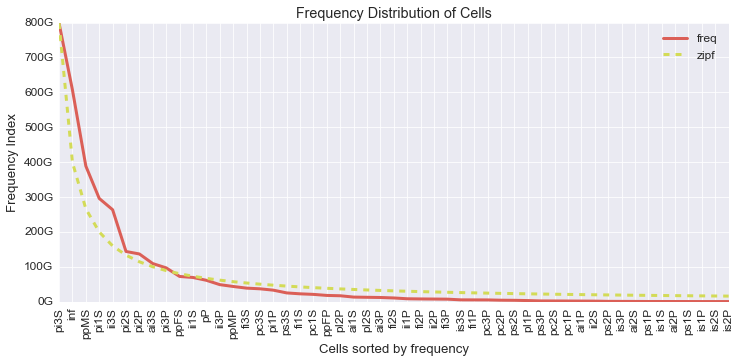

In [15]:
ax=freqCases[["freq","zipf"]].plot(kind="line",style=['-', '--'],
                                   figsize=(12, 5),
                                   rot=90,
                                   linewidth=3,
                                   xticks=range(51),
#                                   xlim=[-1,51]
                                  )
ax.set_xticklabels(freqCases["case"])
#plt.grid()
yticks=ax.get_yticks()
yticks=["%dG"%(y/10e9) for y in yticks]
ax.set_yticklabels(yticks)
#ax.set(yscale="log")
#colorerXTicks(ax)
plt.xlabel('Cells sorted by frequency')
plt.ylabel('Frequency Index')
plt.title('Frequency Distribution of Cells')
plt.show()

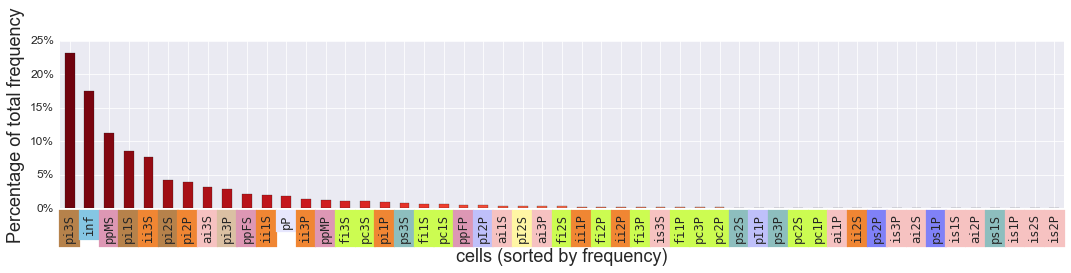

82295.4633986


case       prop
0   pi3S  23.122683
1    inf  17.577510
2   ppMS  11.255055
3   pi1S   8.565403
4   ii3S   7.626844
5   pi2S   4.159705
6   pi2P   3.952208
7   ai3S   3.153858
8   pi3P   2.798527
9   ppFS   2.085418
10  ii1S   1.999538
11    pP   1.766065
12  ii3P   1.406081
13  ppMP   1.252617
14  fi3S   1.115495
15  pc3S   1.059167
16  pi1P   0.946809
17  ps3S   0.717616
18  fi1S   0.642185
19  pc1S   0.595783
20  ppFP   0.508969
21  pI2P   0.481861
22  ai1S   0.371131
23  pI2S   0.353978
24  ai3P   0.337820
25  fi2S   0.299098
26  ii1P   0.232040
27  fi2P   0.217782
28  ii2P   0.208825
29  fi3P   0.198945
30  is3S   0.141969
31  fi1P   0.138241
32  pc3P   0.135289
33  pc2P   0.112029
34  ps2S   0.103873
35  pI1P   0.082632
36  ps3P   0.051658
37  pc2S   0.048212
38  pc1P   0.043794
39  ai1P   0.040066
40  ii2S   0.034547
41  ps2P   0.016110
42  is3P   0.013075
43  ai2S   0.010760
44  ps1P   0.005710
45  is1S   0.005338
46  ai2P   0.003499
47  ps1S   0.002978
48  is1P   0.000611
49  is2S   0.000310
50  is2P   0.000281

In [16]:
freqSomme=freqCases["freq"].sum()
freqCases["prop"]=freqCases["freq"]/freqSomme*100
ax=freqCases["prop"].plot(kind="bar",figsize=(18, 3),
                          rot=90,xticks=range(51),
                          color=sns.color_palette("Reds_r",n_colors=51)
                         )
ax.set_xticklabels(freqCases["case"])
#plt.grid()
#plt.xlabel('Cells sorted by frequency')
ax.set(ylabel=u"pourcentage de fréquence",xlabel=u"cases triées par fréquence",yscale="linear")
ax.set(ylabel=u"Percentage of total frequency",xlabel=u"cells (sorted by frequency)",yscale="linear")
ax.yaxis.label.set_size(18)
ax.xaxis.label.set_size(18)
yticks=ax.get_yticks()
yticks=["%.3g%%"%y for y in yticks]
ax.set_yticklabels(yticks)
colorerXTicks(ax,fSize=10)
# plt.title(u'Distribution de la fréquence entre les cases du paradigme')
# plt.title(u'Cell Frequencies',fontsize=16)
plt.show()
print freqCases.iloc[0]["prop"]/freqCases.iloc[50]["prop"]
freqCases[["case","prop"]]

In [17]:
sFreqCases=freqCases.set_index("case").T[cases].T

In [18]:
sFreqCases=freqCases.sort_values(by="case")
sFreqCases=freqCases.set_index("case").T[cases].T
sFreqCasesSum=sFreqCases["freq"].sum()
sFreqCases["percent"]=sFreqCases["freq"]/sFreqCasesSum
sFreqCases.reset_index(inplace=True)

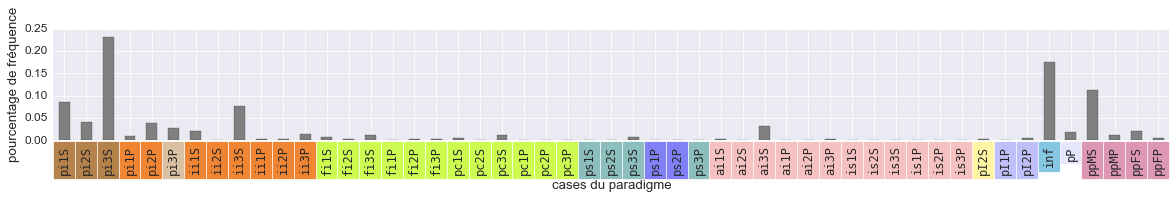

In [19]:
ax=sFreqCases["percent"].plot(kind="bar",
                              figsize=(20, 2),
                              color="grey",
                             )
ax.set_xticklabels(sFreqCases["case"])
colorerXTicks(ax)
#ax.set_ylim([0,0.25])
ax.set(ylabel=u"pourcentage de fréquence",xlabel=u"cases du paradigme",yscale="linear")
#plt.grid()
plt.show()

### Evolution de la fréquence du passé simple 3 en fonction du rang

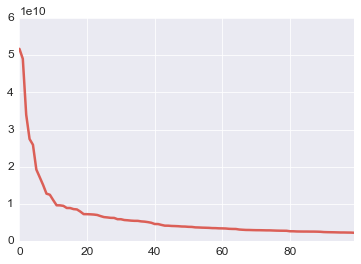

In [20]:
ai3S=lexique[lexique["case"]=="ai3S"].sort_values(by="freq",ascending=False).reset_index()
ax=ai3S["freq"][:100].plot()
plt.show()

# Évaluation de la distribution de fréquence comme indice de défectivité
- avec la fréquence brute FS
- avec la fréquence relative FSN
- avec le log de la fréquence brute FL
- avec le log de la fréquence brute moyenné FLN

### Ajout d'une colonne freqLog

In [21]:
lexique["freqLog"]=np.log(lexique["freq"])

## Distribution des cases par lexème

In [96]:
def lexique2Paradigmes(lexique,values="freq",lAggfunc=lambda x: sum(x)):
    return pd.pivot_table(lexique, values=values, index=['lexeme'], columns=['case'], aggfunc=lAggfunc).reset_index().reindex()

In [51]:
colFreq="freq"
paradigmeFS=lexique2Paradigmes(lexique,"freq")
paradigmeFL=lexique2Paradigmes(lexique,"freqLog")

## Ajout d'une colonne fréquence de lexème

In [53]:
paradigmeFS["freqLexeme"]=paradigmeFS[cases].sum(axis=1,numeric_only=True)
paradigmeFL["freqLexeme"]=paradigmeFL[cases].sum(axis=1,numeric_only=True)

In [57]:
lex3SortedLexemes=paradigmeFS.sort_values("freqLexeme",ascending=False)["lexeme"].tolist()
lex3Paradigme=lexique2Paradigmes(lexique1000,"phono",lAggfunc="first")
lex3Paradigme.set_index("lexeme",inplace=True)

In [99]:
latexLignes=[]
lLexemes=lex3SortedLexemes[:25]
lLexemes=u"beurrer brifer promouvoir accointer affouiller paralyser".split(" ")
lLexemes=[u"paralyser"]
for l in lLexemes:
    latexLignes.append(l)
    lSeries=lex3Paradigme.loc[l].dropna()
    latexLignes.append(makeTabularParadigme(lSeries,dictEtColours))
pyperclip.copy("\n".join(latexLignes))

## Normalisation des fréquences de formes par rapport à la fréquence de lexèmes
on obtient des proportions entre les formes

In [66]:
paradigmeFSN=paradigmeFS.copy()
paradigmeFLN=paradigmeFL.copy()
for case in cases:
    paradigmeFSN[case]=(paradigmeFSN[case]/paradigmeFSN["freqLexeme"])
    paradigmeFLN[case]=(paradigmeFLN[case]/paradigmeFLN["freqLexeme"])

### Index des verbes défectifs et standard

In [49]:
ixDefectif=paradigmeFS[paradigmeFS.lexeme.isin(boyeDefectifs)].lexeme.to_dict()
defectifIx={v:k for k,v in ixDefectif.iteritems()}
ixDefectif,defectifIx

({36: u'abstraire',
  70: u'accroire',
  106: u'adirer',
  126: u'advenir',
  395: u'assavoir',
  565: u'becter',
  579: u'bienvenir',
  691: u'braire',
  740: u'bruire',
  770: u'b\xe9er',
  924: u'chaloir',
  990: u'choir',
  1060: u'clore',
  1117: u'comparoir',
  1246: u'contrefoutre',
  1316: u'courre',
  1485: u'discontinuer',
  1510: u'dissoudre',
  1520: u'distraire',
  1551: u'douer',
  1694: u'd\xe9choir',
  1712: u'd\xe9clore',
  2076: u'd\xe9pourvoir',
  2500: u'enclore',
  2533: u'end\xeaver',
  2642: u'ensuivre',
  2757: u'ester',
  2831: u'extraire',
  2850: u'faillir',
  2971: u'forclore',
  2973: u'forfaire',
  3005: u'foutre',
  3032: u'frire',
  3070: u'f\xe9rir',
  3250: u'g\xe9sir',
  3370: u'impartir',
  3715: u'malfaire',
  3817: u'messeoir',
  3902: u'moufeter',
  3903: u'moufter',
  3908: u'mourir',
  3955: u'm\xe9faire',
  4069: u'oindre',
  4116: u'ou\xefr',
  4182: u'parfaire',
  4230: u'pa\xeetre',
  4371: u'poindre',
  4607: u'qu\xe9rir',
  4667: u'raire',

In [29]:
ixVerbes=paradigmeFS.lexeme.to_dict()
lexemeLabels=ixVerbes.values()

# Plotter les distributions des défectifs par famille
- clore, déclore, éclore, enclore, forclore

In [51]:
def plotFamille(famille,gParadigme,ylim=None,width=1,yscale="linear",lPalette="Greys"):
    dfAX=(gParadigme[gParadigme["lexeme"].isin(famille)].set_index("lexeme").loc[famille][cases].T)
    ax=dfAX.plot(kind="bar",
                 figsize=(30,5),
                 width=width,
                 color=["r"]+sns.color_palette(lPalette,n_colors=len(dfAX)-1),
                )
    colorerXTicks(ax)
    ax.set(yscale=yscale,ylabel=u"occurrences par million de mots")
    ax.legend(loc="upper left")
    if ylim:
        ax.set_ylim([0,ylim])
    jointFamille="".join([l.capitalize() for l in famille])
    if yscale=="linear":
        strScale=""
    else:
        strScale=yscale.capitalize()+"-"
    plt.savefig(repHDR+u'Lex3-BP-%s%s-Verbes.pdf'%(strScale,jointFamille), dpi=300, bbox_inches="tight")
    plt.show()

### CLORE

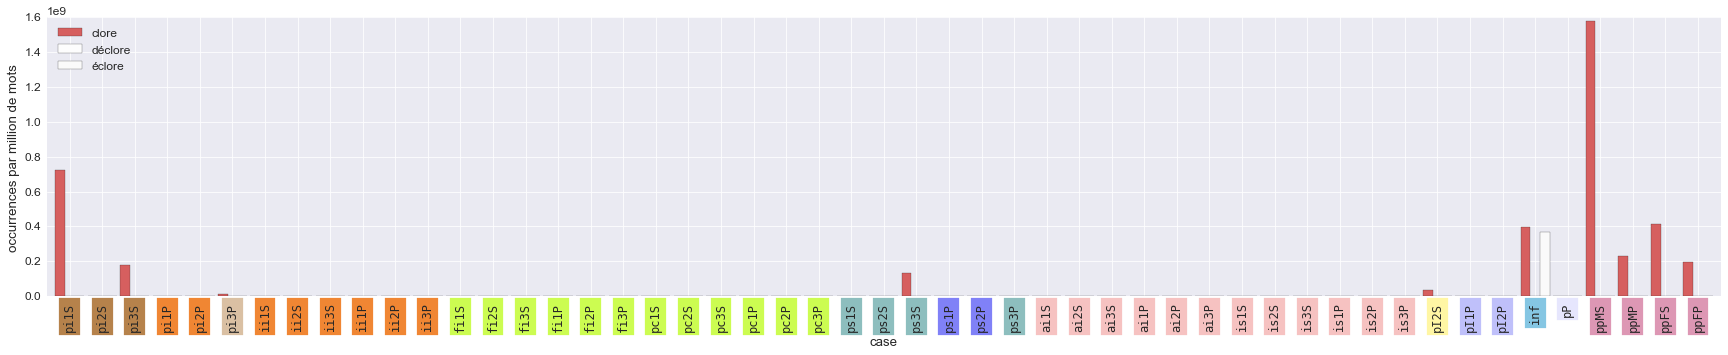

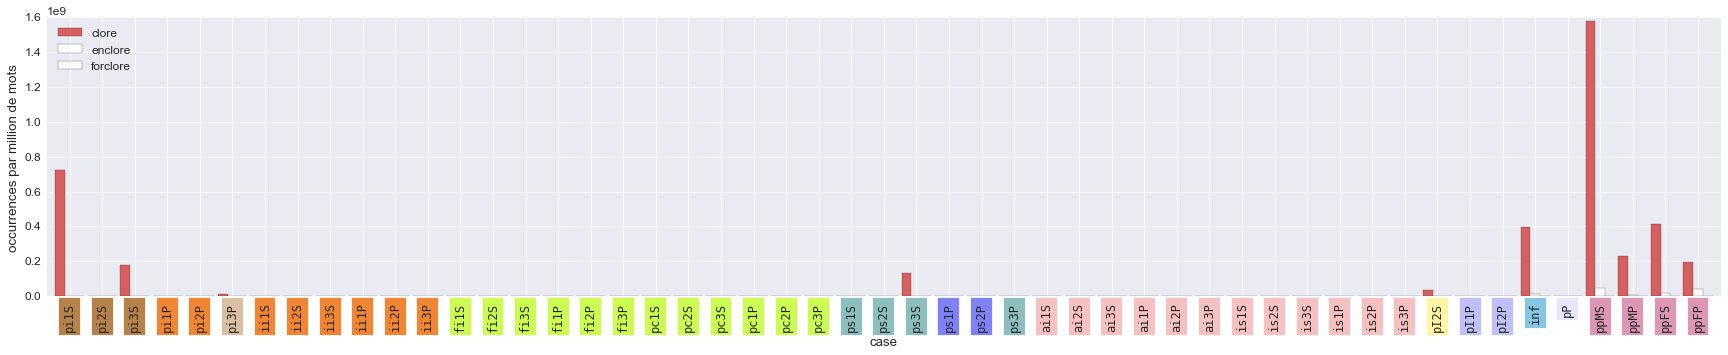

In [52]:
famille=u"clore, déclore, éclore".split(", ")
plotFamille(famille,paradigmeFS,width=.9,
#            ylim=1.E13,
           )
famille=u"clore, enclore, forclore".split(", ")
plotFamille(famille,paradigmeFS,width=.9,
#            ylim=1.E13,
           )

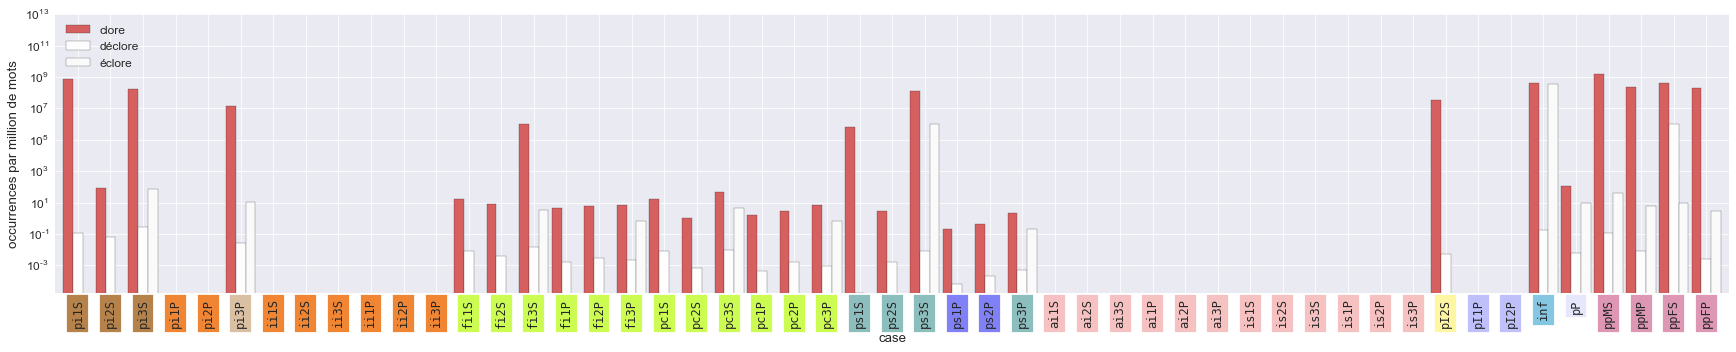

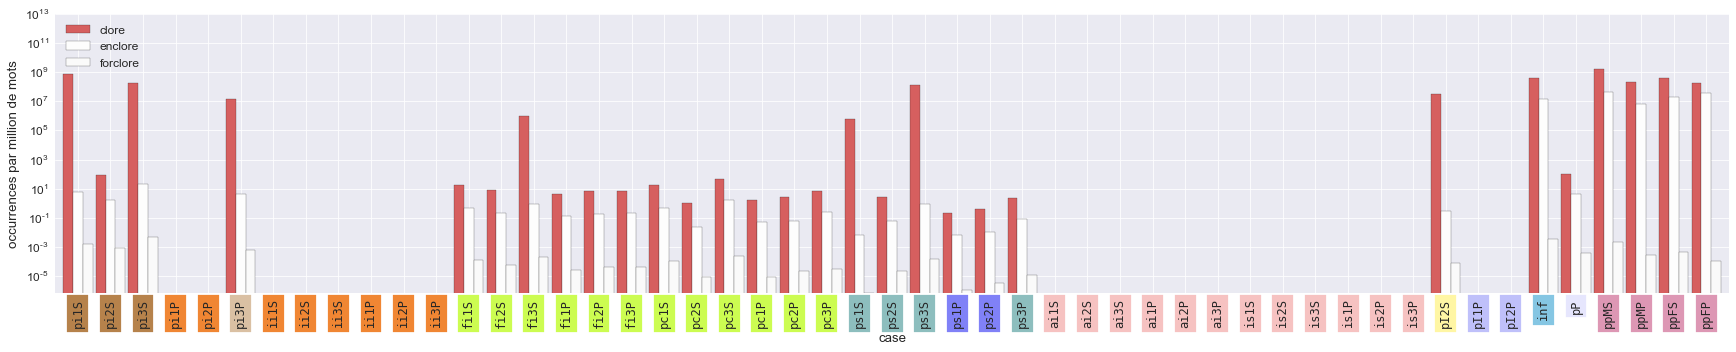

In [32]:
famille=u"clore, déclore, éclore".split(", ")
plotFamille(famille,paradigmeFS,width=.9,
            ylim=1.E13,yscale="log",
           )
famille=u"clore, enclore, forclore".split(", ")
plotFamille(famille,paradigmeFS,width=.9,
            ylim=1.E13,yscale="log",
           )

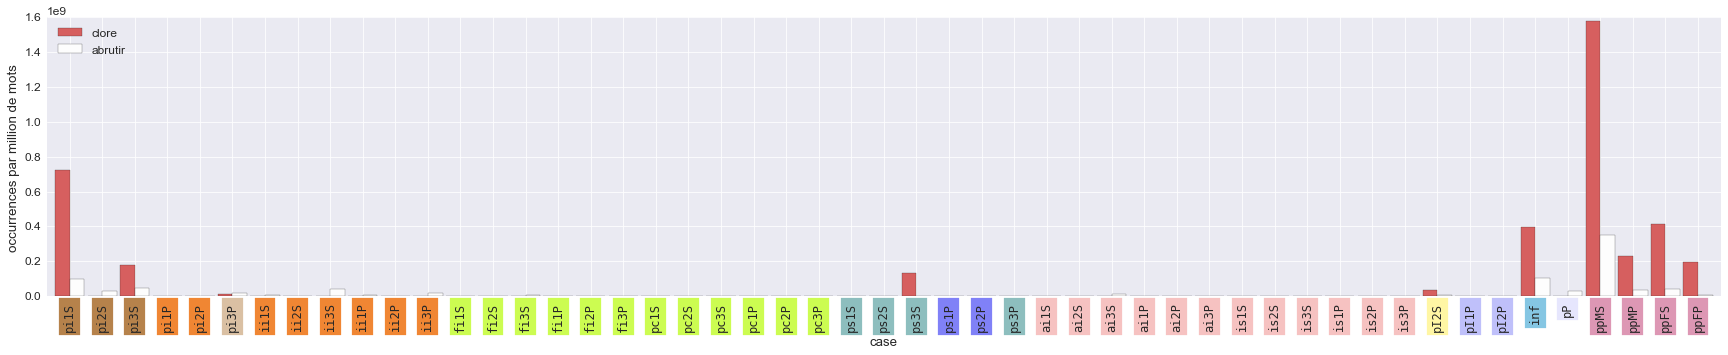

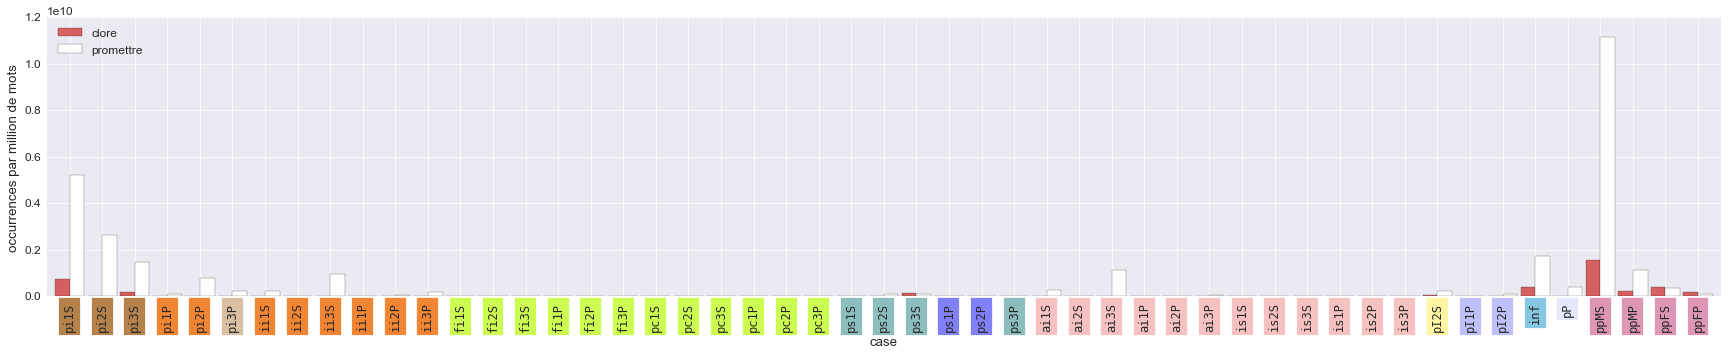

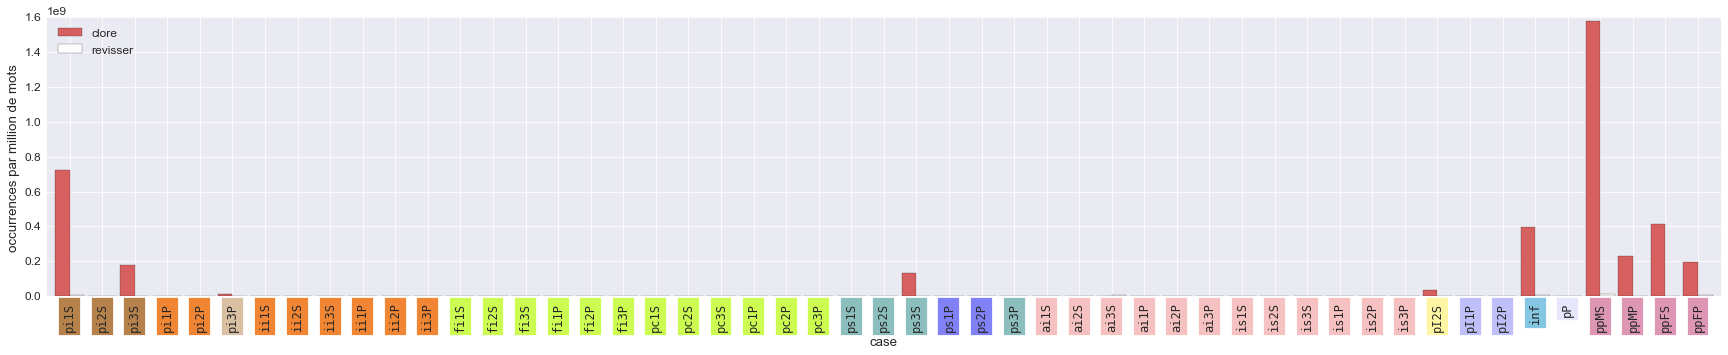

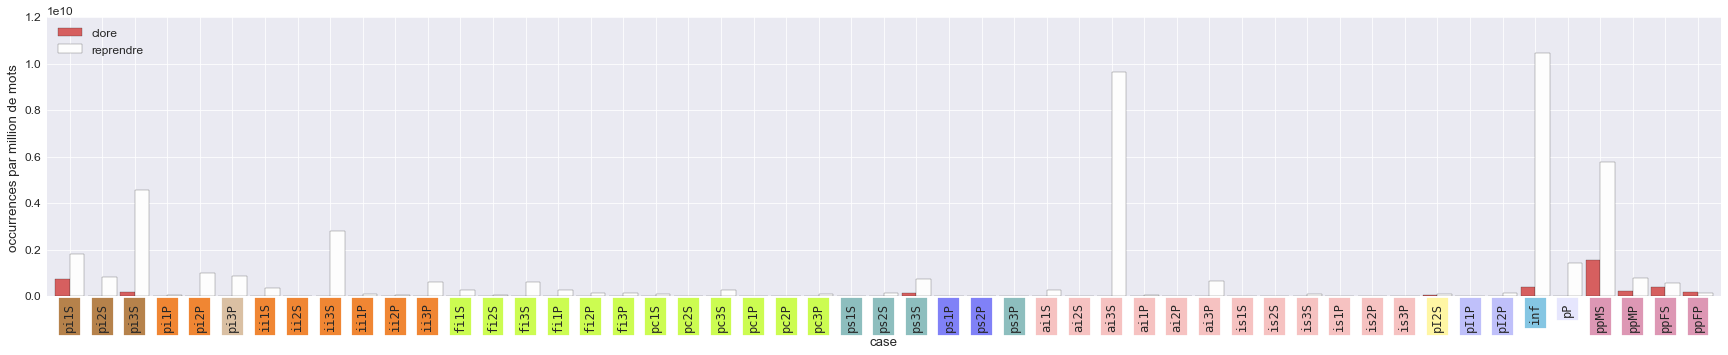

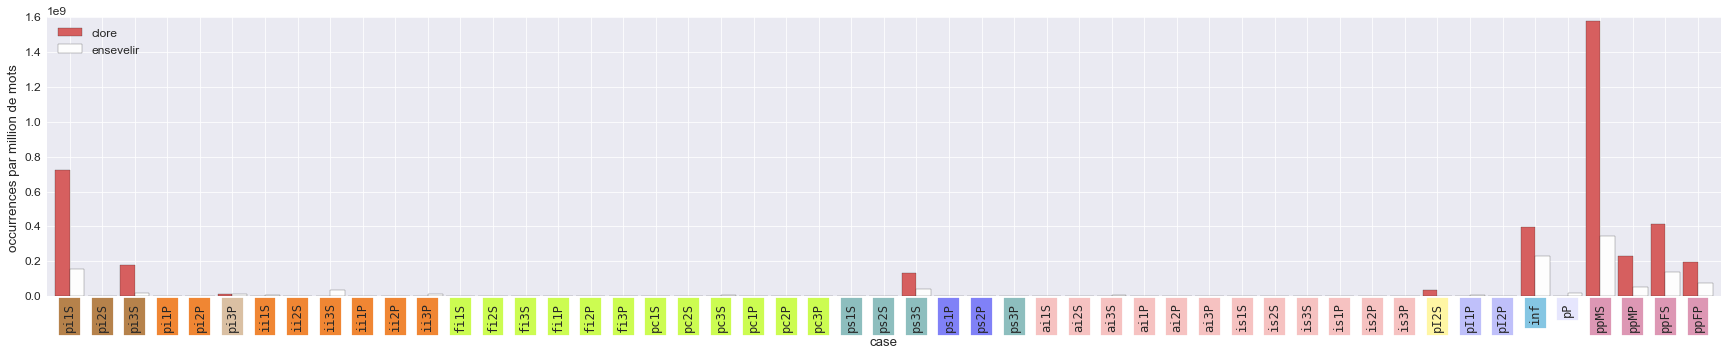

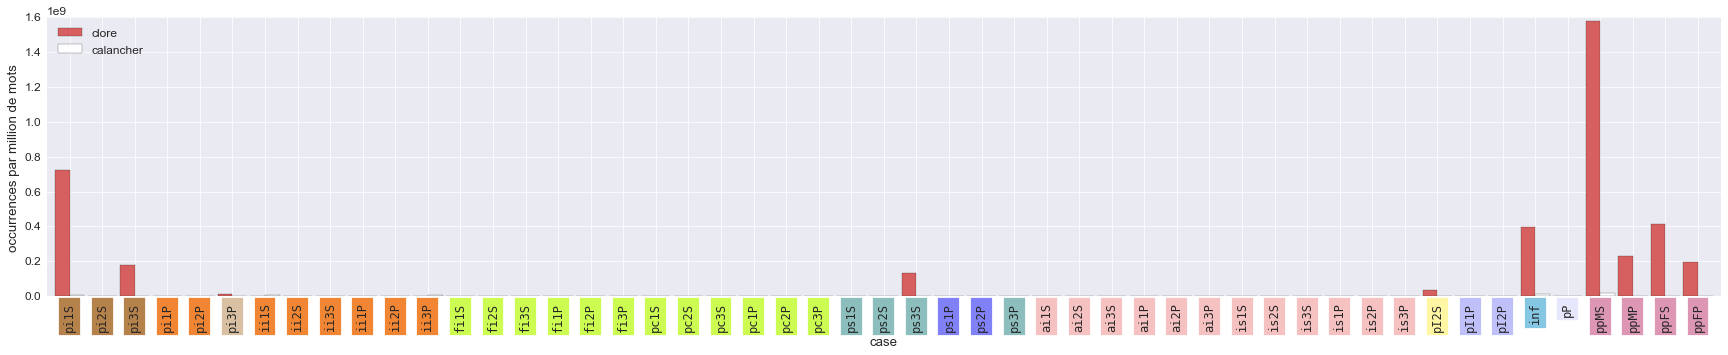

In [33]:
voisins=u"abrutir promettre revisser reprendre ensevelir calancher".split(" ")
for voisin in voisins:
    plotFamille([u"clore",voisin],paradigmeFS,
                width=.9,
               )

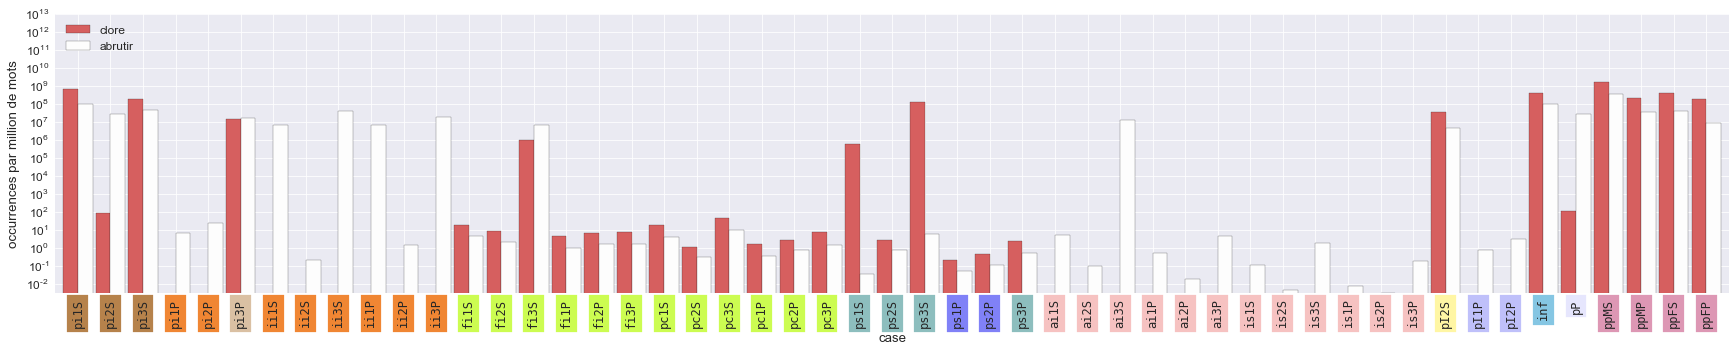

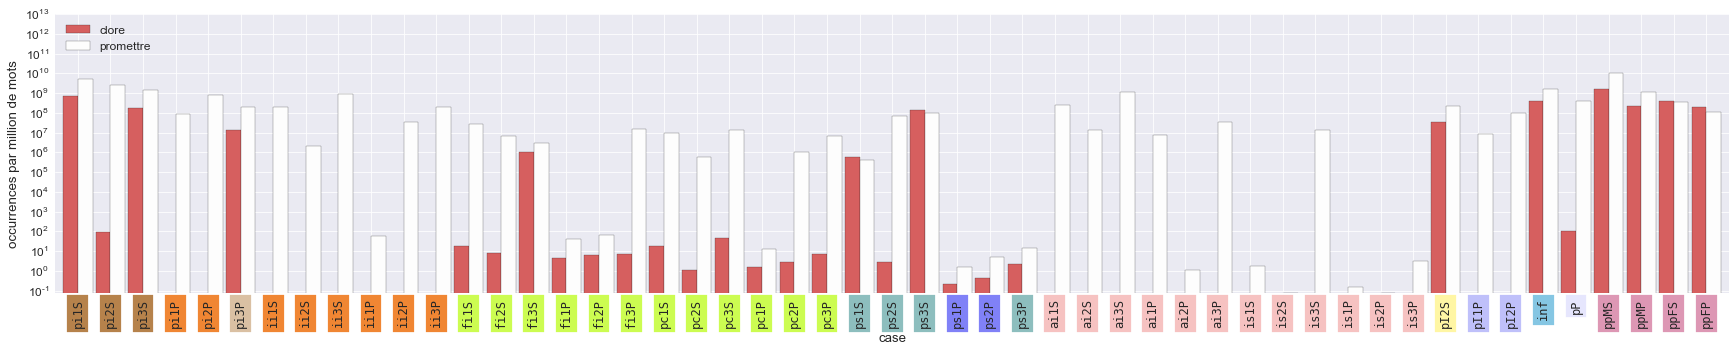

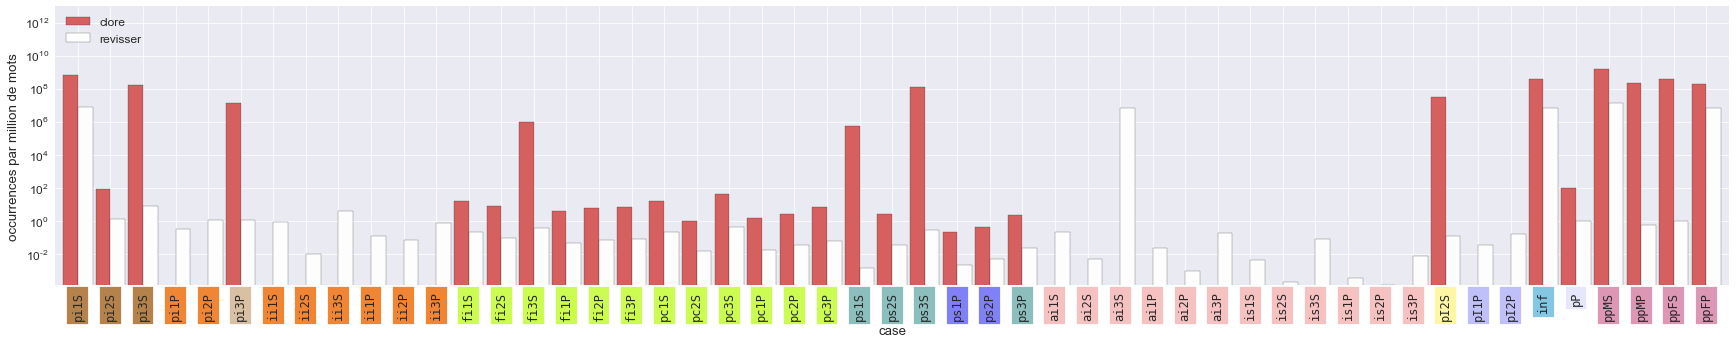

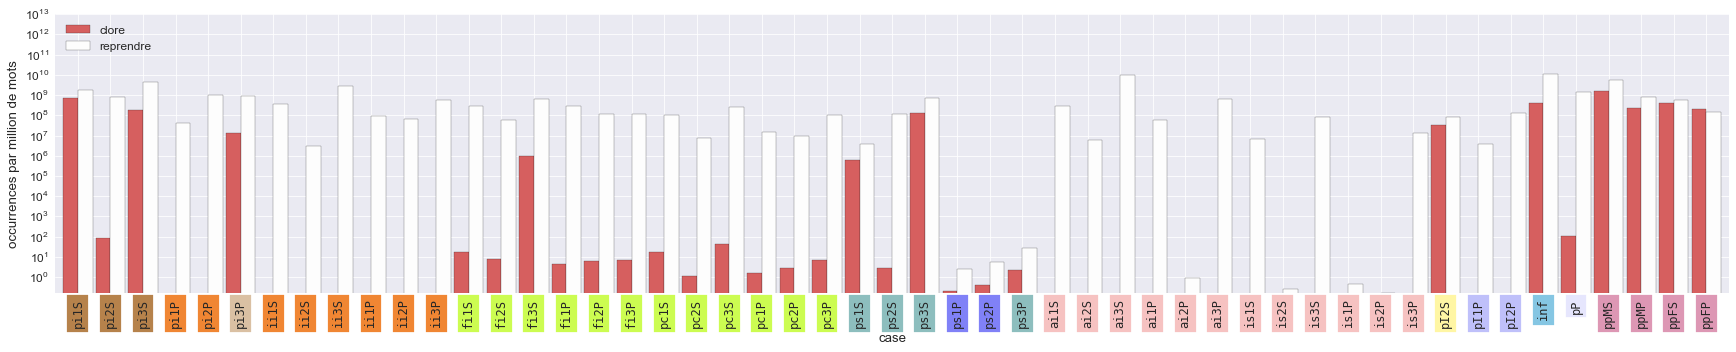

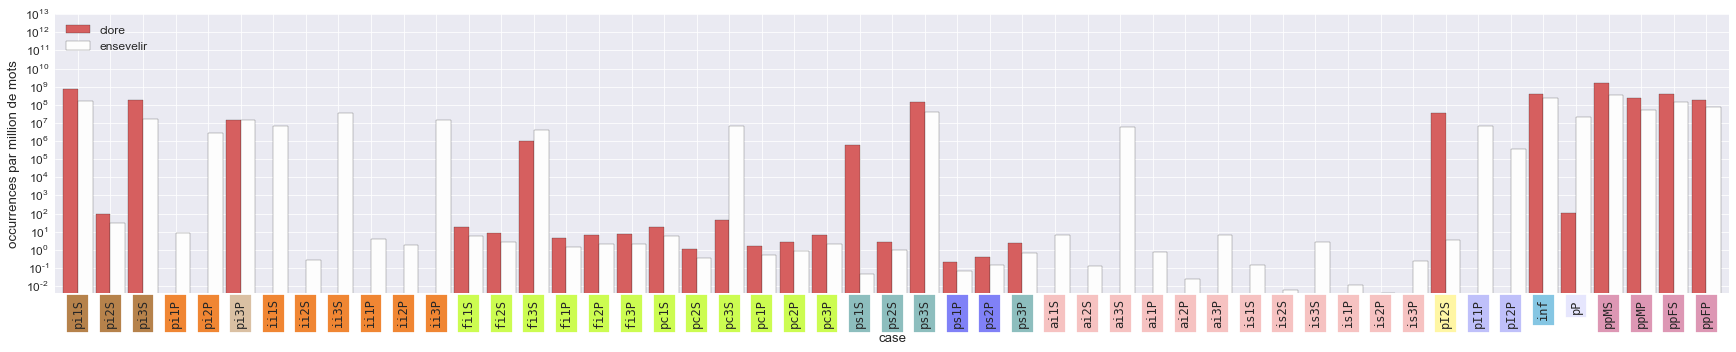

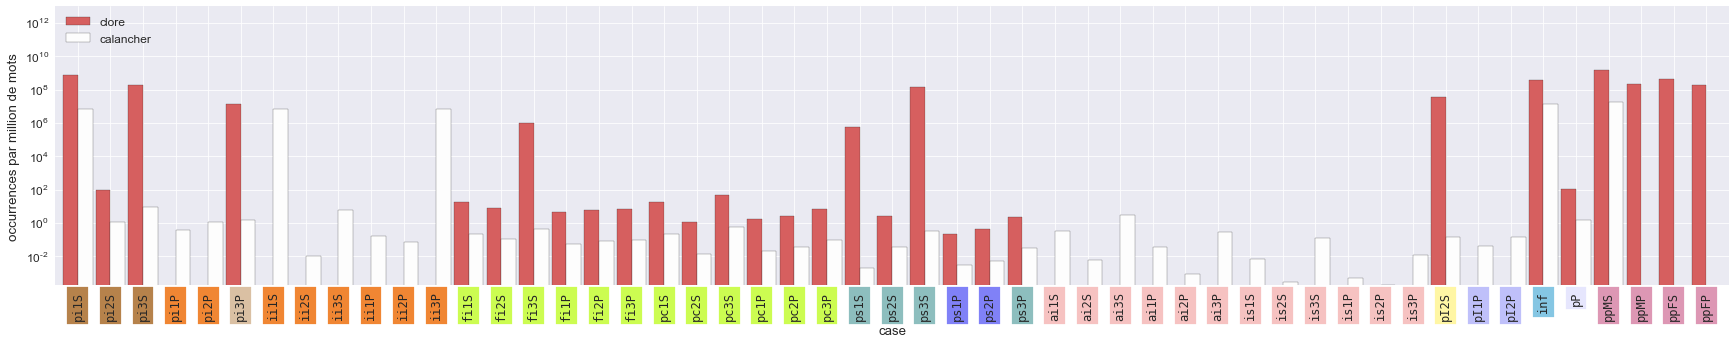

In [34]:
voisins=u"abrutir promettre revisser reprendre ensevelir calancher".split(" ")
for voisin in voisins:
    plotFamille([u"clore",voisin],paradigmeFS,
                width=.9,
                ylim=1.E13,yscale="log",
               )

### DISTRAIRE

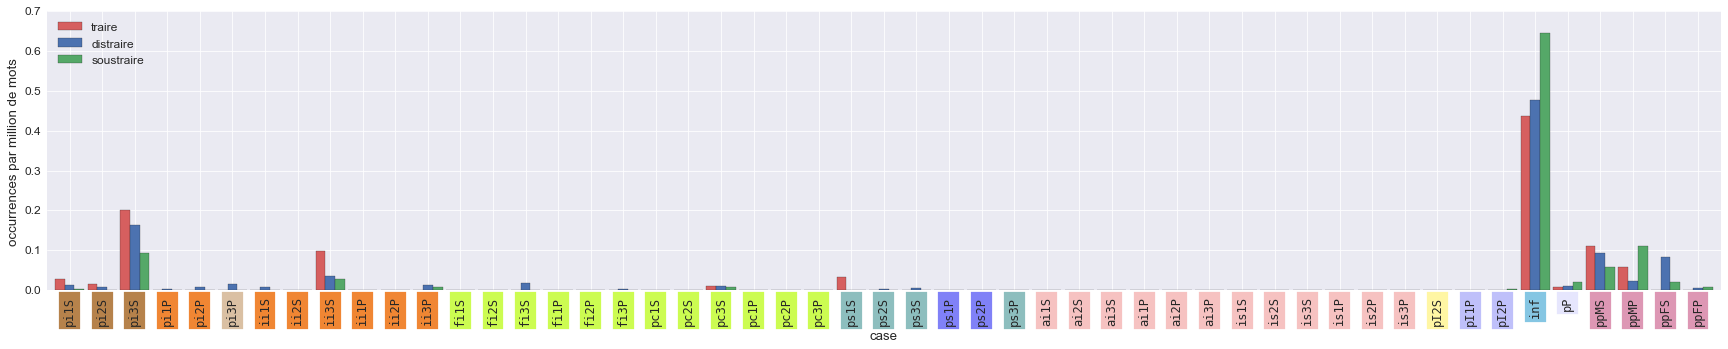

In [75]:
famille=u"traire, distraire, soustraire".split(", ")
plotFamille(famille,paradigmeFSN,width=.9,#yscale="log",
            lPalette="deep"
#            ylim=1.E13,
           )


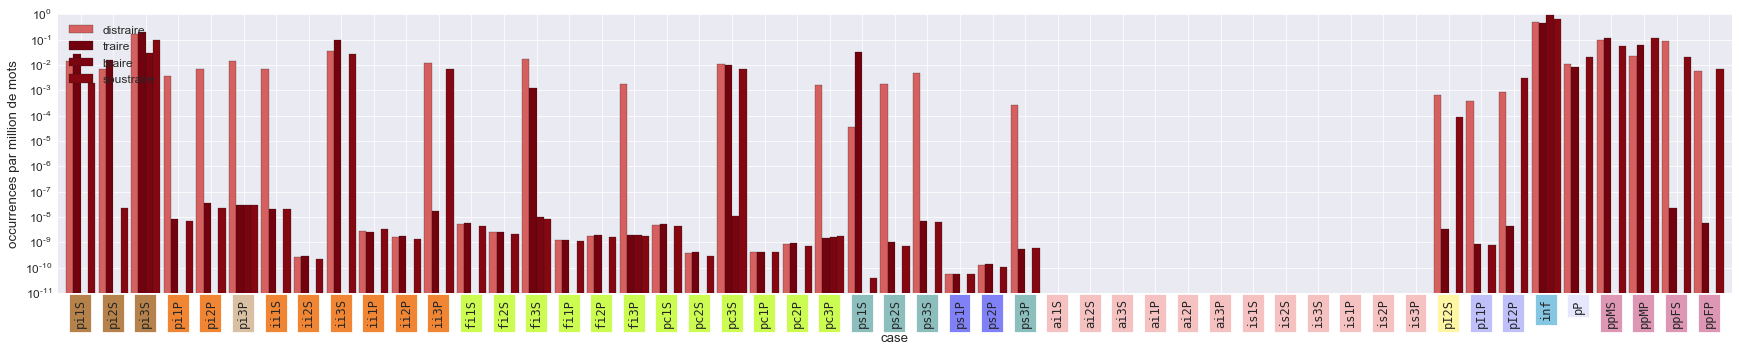

In [72]:
famille=u"distraire, traire, braire, soustraire".split(", ")
plotFamille(famille,paradigmeFSN,width=.9,yscale="log",
            lPalette="Reds_r"
#            ylim=1.E13,
           )


# Clusterisation des distributions de fréquences

## Préparation des données

### Découpage du tableau

In [35]:
def preparerDataRaw(gParadigme):
    paradigme=gParadigme[cases].copy()
    if "lexeme" in paradigme.columns:
        lexemeLabels=paradigme["lexeme"].tolist()
        del paradigme["lexeme"]
    if "freqLexeme" in paradigme.columns:
        del paradigme["freqLexeme"]

    if "case" in paradigme.columns:
        del paradigme["case"]
    paradigme.fillna(value=0,inplace=True)

    data_raw=paradigme.iloc[:].values
    return data_raw

## Normalisation

In [36]:
from sklearn import preprocessing

def normaliserDataRaw(data_raw):
    return preprocessing.normalize(data_raw)

In [37]:
def dendrogramLabels(id):
    return lexemeLabels[id]

In [38]:
def dendrogramClustersLabels(id):
    if id in clustersLabels:
        return ", ".join(clustersLabels[id][:5])
    else:
        return id

## Clusterisation hiérarchique => dendrogramme

In [39]:
import sys
sys.getrecursionlimit()

1000

In [40]:
sys.setrecursionlimit(100000)

### Clusterisation

In [41]:
from scipy.cluster import hierarchy as hc

In [42]:
def getLinkage(gParadigme):
    data_raw=preparerDataRaw(gParadigme)
    data=normaliserDataRaw(data_raw)
    Z=hc.linkage(data,method='ward')
    return Z

### Plotter le dendrogramme sans troncation
Le dendrogramme sans troncation permet d'explorer les voisinages des différents verbes avec les distinctions maximales

In [43]:
def plotDendrogram(Z,parType="",p=None,truncate_mode=None):
    plt.figure(figsize=(2000,600),)
    if truncate_mode:
        leaf_label_func=dendrogramClustersLabels
        figInsert=u"-%s-%d-"%(parType,p)
    else:
        leaf_label_func=dendrogramLabels
        figInsert=u"-%s-"%(parType)

    dendrogram = hc.dendrogram(Z,
                               leaf_label_func=leaf_label_func,
                               leaf_font_size=10.,
                               p=p,truncate_mode=truncate_mode,
                              )
    plt.savefig(repHDR+u'Lex3-Dendrogram%sVerbes.pdf'%figInsert, dpi=300, bbox_inches="tight")

### Récupération des clusters avec troncation
- pour obtenir les clusters, on fait appel à fcluster qui fournit un numéro de cluster pour chaque index de data
    - pour obtenir les noms des verbes, on fait la correspondance entre le numéro obtenu et lexemeLabels
    - pour obtenir les "noms" des clusters, il faut lancer dendrogram une première fois sans plot => R["ivl"]

In [44]:
lexemeLabels=ixVerbes
Z=getLinkage(paradigmeFS)

In [46]:
nbClusters=6000
from scipy.cluster.hierarchy import fcluster
clusters=fcluster(Z, t=nbClusters, criterion='maxclust')
clusters

array([2260, 3315,  130, ..., 3874, 5008, 2389], dtype=int32)

In [47]:
plt.figure(
#    figsize=(1000,20),
    dpi=72)
#%time dendrogram = hc.dendrogram(Z,truncate_mode="lastp",p=50)
R=dendrogram = hc.dendrogram(Z,
                           p=nbClusters,truncate_mode="lastp",
                           no_plot=True
                          )

R["ivl"] #contient les 'noms' des clusters du plot


['2163',
 '4479',
 '3072',
 '880',
 '3979',
 '15',
 '6013',
 '5485',
 '2872',
 '5676',
 '2903',
 '279',
 '5800',
 '178',
 '3584',
 '3991',
 '6483',
 '190',
 '2306',
 '42',
 '288',
 '2433',
 '3892',
 '216',
 '898',
 '5212',
 '3940',
 '6106',
 '4742',
 '1551',
 '1784',
 '3264',
 '1000',
 '5908',
 '1745',
 '1480',
 '444',
 '5906',
 '6397',
 '2036',
 '3492',
 '2590',
 '2024',
 '4576',
 '6535',
 '1618',
 '2448',
 '5392',
 '5795',
 '3221',
 '4590',
 '258',
 '4772',
 '3304',
 '6480',
 '182',
 '2791',
 '5015',
 '4380',
 '2079',
 '3411',
 '6180',
 '970',
 '4397',
 '973',
 '1401',
 '5112',
 '6108',
 '657',
 '4528',
 '240',
 '3989',
 '5456',
 '4235',
 '5512',
 '2390',
 '2705',
 '6432',
 '1062',
 '1427',
 '2013',
 '5684',
 '1350',
 '2629',
 '5993',
 '1906',
 '6101',
 '5657',
 '6243',
 '2901',
 '5753',
 '3608',
 '2567',
 '4940',
 '1839',
 '2121',
 '4096',
 '4505',
 '1786',
 '134',
 '5717',
 '306',
 '3044',
 '1543',
 '3369',
 '5770',
 '1363',
 '2523',
 '5514',
 '3370',
 '4037',
 '4087',
 '3391',
 '3

In [48]:
clustersLabels={}
# for nC,c in enumerate(R["ivl"]):
#     clustersLabels[nC]=[]
for nL,l in enumerate(clusters):
#    print nL,l
    cL=R["ivl"][l-1]
    nomC=u"%d-%s"%(l,cL)
    if nomC not in clustersLabels:
        clustersLabels[nomC]=[]
    clustersLabels[nomC].append(lexemeLabels[nL])
clustersLabels

{u'1410-2522': [u'inventorier'],
 u'3858-4006': [u'gambader'],
 u'2841-1223': [u'ramer'],
 u'3721-2331': [u'\xe9pouser'],
 u'264-2684': [u'entrecouper'],
 u'4892-4084': [u'policer'],
 u'2221-6442': [u'recracher'],
 u'2872-36': [u'tripoter'],
 u'4718-5291': [u'estimer'],
 u'4481-2383': [u'amener'],
 u'3914-6179': [u'resplendir'],
 u'1555-4982': [u'a\xe9rer'],
 u'4113-4243': [u'd\xe9signer'],
 u'2334-6387': [u'remonter'],
 u'3596-1546': [u'fumiger'],
 u'1223-5195': [u'impl\xe9menter'],
 u'929-2596': [u'armer'],
 u'778-4801': [u'cloquer'],
 u'2507-3313': [u'imposer'],
 u'4274-3278': [u'gaminer'],
 u'4107-1452': [u'lisser'],
 u'11-2903': [u'ancrer'],
 u'2473-2443': [u'r\xe9amorcer'],
 u'1912-1651': [u'corroder'],
 u'1620-5618': [u'r\xe9chauffer'],
 u'2774-3988': [u'd\xe9voiler'],
 u'1577-3804': [u'tarder'],
 u'934-114': [u'd\xe9porter'],
 u'4870-4176': [u'envier'],
 u'5017-3185': [u'pantoufler'],
 u'3957-6411': [u'\xe2nonner'],
 u'2225-3646': [u'lancer'],
 u'2381-5828': [u'articuler'],
 u'

In [57]:
for v in boyeDefectifs:
    for c in clustersLabels:
        if v in clustersLabels[c]:
            print v,c
            print clustersLabels[c]
            print

abstraire 2790-2051
[u'abstraire']

accroire 1201-614
[u'accroire', u'adirer', u'aiguayer', u'alambiquer', u'alester', u'apetisser', u'argoter', u'assavoir', u'attraire', u'aveindre', u'bayer', u'bichoter', u'bienvenir', u'bouliner', u'breller', u'bretauder', u'brouir', u'chauvir', u'comparoir', u'courre', u'couturer', u'd\xe9chouer', u'd\xe9f\xe2cher', u'd\xe9murger', u'd\xe9patrier', u'd\xe9soeuvrer', u'embatre', u'ester', u'failler', u'forfaire', u'forpaiser', u'f\xe9rir', u'galantiser', u'mainmettre', u'malfaire', u'maquereller', u'm\xe9faire', u'portraire', u'pouiller', u'pyrrhoniser', u'qu\xe9rir', u'raboutir', u'ragrandir', u'ravoir', u'redonder', u'r\xe9ciproquer', u'r\xe9franger', u'sniffer', u'sorguer', u'sphac\xe9ler', u'superfinir', u'surglacer', u'taponner', u'tartir', u'troussequiner', u'valeter', u'vaser', u'\xe9cher', u'\xe9perdre', u'\xe9poutier']

adirer 1201-614
[u'accroire', u'adirer', u'aiguayer', u'alambiquer', u'alester', u'apetisser', u'argoter', u'assavoir', u'

In [55]:
(clustersLabels[u"3830-404"])

[u'g\xe9sir']

In [ ]:
plotDendrogram(Z,parType=u"Freq",p=nbClusters,truncate_mode="lastp")

In [ ]:
plotDendrogram(Z,parType=u"Freq")

### Plotter les voisins de défectifs

In [21]:
def plotVoisins(voisins,gParadigme,ylim=None):
    for lexeme in voisins:
        dfAX=gParadigme[gParadigme["lexeme"]==lexeme].set_index("lexeme")[cases].T
        ax=dfAX.plot(kind="bar",
                     figsize=(20,5),
                     color=sns.color_palette("hls"),
                    )
        xlabels=ax.get_xticklabels()
        for xlabel in xlabels:
            xtext=xlabel.get_text()
            xlabel.set_backgroundcolor(cellColors[xtext])
        if ylim:
            ax.set_ylim([0,ylim])
        plt.show()

### Voisins de défectifs (fréquence standard FS, fréquence log FL)
- clore
    - FS : revisser,(**clore**,(abrutir,promettre))
    - FL : (**clore**,(corrompre,méconnaître)),((recoudre,réécrire),(mander,étriper))
- distraire
    - FS : ((instruire,(séduire,(**distraire**, extraire))),(régénérer,(construire,détruire)))
    - FL : (((garantir, investir),(enrichir, rafraîchir)),(blâmer, **distraire**))
- abstraire
    - FS : ((**abstraire**, pocher),(distancer, proscrire))
    - FL : ((**abstraire**, parfaire),(peinturlurer,(civiliser, daller)))
- soustraire
    - FL : (brutaliser,débrider),(**soustraire**,étayer)
- extraire
    - FL : (dorloter,désamorcer),(**extraire**,restituer)
- retraire, raire
    - FL : grêler,(**raire**,**retraire**)
- traire
    - FL : (**traire**,**frire**),((**clore**,(corrompre,méconnaître)),((recoudre,réécrire),(mander,étriper))
    
    
Il y a aussi quelques vestiges
- portraire, attraire
    - FS : éclore, crémer, époutier, éperdre, écher, vaser, valeter, troussequiner, tartir, taponner, surglacer, superfinir, sphacéler, sorguer, sniffer, réfranger, réciproquer, redonder, ravoir, ragrandir, raboutir, quérir, pyrrhoniser, pouiller, portraire, méfaire, maquereller, malfaire, mainmettre, galantiser, férir, forpaiser, forfaire, failler, ester, embatre, désoeuvrer, dépatrier, démurger, défâcher, déchouer, couturer, courre, comparoir, chauvir, brouir, bretauder, breller, bouliner, bienvenir, bichoter, bayer, aveindre, attraire, assavoir, argoter, apetisser, alester, alambiquer, aiguayer, accroire, adirer, rassir, occire, reclure, dérayer, rechaper, retordre, regrossir, pionner, coqueter, partouser, hercher, tictaquer, ambler, apponter, jodler, luncher, équeuter, émulsifier, zester, tiller, stripper, soumissionner, signaliser, scolariser, réincarcérer, réargenter, ressemer, resalir, rentamer, rempoter, redémolir, recongeler, reclouer, recarreler, pifer, pastiller, parafer, paginer, inférioriser, hotter, escher, enkyster, enjuiver, encliqueter, embraquer, déventer, désinsectiser, désincruster, désaccoupler, dépoudrer, dénazifier, décriminaliser, déconditionner, décomprimer, dissimiler, diligenter, cureter, coupailler, corréler, contremander, cliver, avitailler, chansonner, quarter, manutentionner, maximiser, exemplifier, trompeter, crosser, maquereauter, syndicaliser, scratcher, rober, rechasser, farter, alcaliniser, alphabétiser, télédiffuser, shampooiner, réabonner, revoter, retuber, reposséder, remprunter, criminaliser, recorder, implémenter, décuver, dépolluer, raller, pleuvioter, varapper, tatillonner, mésuser, lapiner, endêver, dansotter, couchailler, bavocher, bostonner, obvier, rôdailler, égrainer, écornifler, versifier, systématiser, régionaliser, remboîter, reloquer, relaisser, refeuilleter, recogner, reblanchir, rabonnir, pasteuriser, paperasser, maroufler, entrebattre, entr'aimer, engraver, enclouer, encaserner, empanner, désensabler, désenchaîner, désembuer, dépiler, dépaver, démuseler, délustrer, débobiner, correctionnaliser, chabler, cancériser, braser, boyauter, anatomiser, bluter, déconsigner, rapointir, prolétariser, embobeliner, décaisser, désengourdir, mortaiser, vulgariser, décrêper, rebander, désencrasser, rassortir, réséquer, boulanger, réassurer
    - FL : éperdre, écher, vaser, valeter, tartir, sniffer, ravoir, quérir, portraire, galantiser, férir, failler, ester, désœuvrer, démurger, déchouer, couturer, courre, comparoir, chauvir, brouir, bayer, attraire, accroire, assavoir
 

### CLORE

In [22]:
print "voisins de fréquence brute"
plotVoisins(u"abrutir promettre clore revisser reprendre ensevelir calancher".split(" "),paradigmeFS,ylim=1.2E10)

voisins de fréquence brute


NameError: name 'paradigmeFS' is not defined

In [ ]:
print "voisins de fréquence log"
plotVoisins(u"corrompre méconnaître clore mander étriper recoudre réécrire".split(" "),paradigmeFS,ylim=1.6E9)

### DISTRAIRE

In [ ]:
print "voisins de fréquence brute"
plotVoisins(u"instruire séduire distraire extraire régénérer construire détruire".split(" "),paradigmeFS,ylim=2.5E9)

In [ ]:
print "voisins de fréquence log"
plotVoisins(u"garantir investir enrichir rafraîchir blâmer distraire".split(" "),paradigmeFS,ylim=2.5E9)

### ABSTRAIRE

In [ ]:
print "voisins de fréquence brute"
plotVoisins(u"abstraire pocher distancer proscrire".split(" "),paradigmeFS,ylim=10E7)

In [ ]:
print "voisins de fréquence log"
plotVoisins(u"garantir investir enrichir rafraîchir blâmer distraire".split(" "),paradigmeFS,ylim=2.5E9)

### Lister les défectifs de Boyé(2000) dans les différents clusters

In [ ]:
for cl in clustersLabels:
    print "cluster",cl,len(clustersLabels[cl])
    print u"défectifs",", ".join([l for l in clustersLabels[cl] if l in boyeDefectifs])
    print "verbes",", ".join(clustersLabels[cl])
    print
#    print ", ".join(clusters[cl])

## Clusterisation par KMeans

### Choix du nombre de clusters
Calcul du WCSS (within cluster sum of squares)
kmeans.inertia_ est la valeur du wcss du modèle.

In [ ]:
from sklearn.cluster import KMeans
wcss={}
for i in range(1,55):
    kmeans=KMeans(n_clusters=i,init="k-means++",max_iter=300,n_init=10)
    kmeans.fit(data)
    wcss[i]=kmeans.inertia_

In [ ]:
dfWCSS=pd.DataFrame.from_dict(wcss,orient="index")
dfWCSS.plot(figsize=(10,5))

In [ ]:
dfWCSS.diff().plot(figsize=(20,5),xticks=(np.arange(0, 50, step=1))
)


### Clusterisation autour de K points
k-means++ est une stratégie d'initialisation qui permet d'éviter une trappe d'optimisation locale

In [ ]:
nbClusters=7
kmeans=KMeans(n_clusters=nbClusters,init="k-means++")
y_kmeans=kmeans.fit_predict(data)

In [ ]:
lexemeType={}
for nY,y in enumerate(y_kmeans):
    lexemeType[lexemeLabels[nY]]=y
specialLexemes=boyeDefectifs#[u"être",u"avoir",u"pouvoir",u"savoir",u"faire"]
for lex in specialLexemes:
    if lex in lexemeType:
        print lex,lexemeType[lex]

In [ ]:
allLexemes=True
typeLexemes = {}
for k, v in lexemeType.iteritems():
    if k in specialLexemes or allLexemes:
        typeLexemes[v] = typeLexemes.get(v, [])
        typeLexemes[v].append(k)

### plotter les distributions correspondant aux K centres

In [ ]:
pdKMeans=pd.DataFrame(kmeans.cluster_centers_,columns=cases).transpose()

In [ ]:
for i in range(nbClusters):
    iSum=float(pdKMeans[i].sum())
#    print iSum
    pdKMeans[i]=pdKMeans[i]/iSum
#    print pdKMeans[i]
    ax=pdKMeans[i].plot(kind="bar",figsize=(10, 3))
    ax.set_ylim([0,1])
    specLexI=[]
    for l in specialLexemes:
        if l in typeLexemes[i]:
            specLexI.append(l)
            if len(specLexI)>=10:
                break
    nPadLex=5-len(specLexI)
    if nPadLex>0:
        specLexI=specLexI+typeLexemes[i][:nPadLex]
    plt.title("Type %d => %d: "%(i,len(typeLexemes[i]))+",".join(specLexI)+u"\n")
    plt.show()

In [ ]:
for element in typeLexemes:
    print element,len(typeLexemes[element]),typeLexemes[element][:10]

In [ ]:
dfTemp=paradigme[cases].T.isnull().sum()
indexFormes1=dfTemp[dfTemp>=45].index.tolist()
for ix in indexFormes1:
    lexeme=paradigme.iloc[ix]["lexeme"]
    print lexeme,lexemeType[lexeme]
    ax=(paradigme[paradigme["lexeme"]==lexeme].set_index("lexeme")[cases].T.iloc[1:]).plot(kind="bar",figsize=(20,5))
    ax.set_ylim([0,1])
    plt.show()

### Comparaison des distributions de formes entre des voisins potentiels de CLORE

In [45]:
(paradigme[paradigme.lexeme.isin(u"clore corrompre méconnaître".split(" "))].set_index("lexeme")[cases].T.iloc[1:]).plot(kind="bar",figsize=(20,5))

NameError: name 'paradigme' is not defined

In [ ]:
(paradigme[paradigme.lexeme.isin(u"clore abrutir promettre".split(" "))].set_index("lexeme")[cases].T.iloc[1:]).plot(kind="bar",figsize=(20,5))